# Homework 4

#### Sitong Ju
#### USC ID: 8791155953
#### email: sitongju@usc.edu

In [1]:
#jvm.stop()

In [2]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import weka.core.jvm as jvm
import javabridge
jvm.start()
from weka.classifiers import Classifier, Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['D:\\Anaconda\\lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'D:\\Anaconda\\lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'D:\\Anaconda\\lib\\site-packages\\javabridge\\jars\\cpython.jar', 'D:\\Anaconda\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'D:\\Anaconda\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


## 1. The LASSO and Boosting for Regression

### 1(a) Download the Communities and Crime data. Use the first 1495 rows of data as the training set and the rest as the test set.

In [3]:
attrs = []
with open('../data/communities.names', 'r') as f:
    lines = f.readlines()
    for l in lines:
        if (l.startswith('@attribute')):
            attrs.append(l.split(" ")[1])
            
print(len(attrs), "attributes in totall")
print("5 non-predictive attributes to be ignored:", attrs[:5])

128 attributes in totall
5 non-predictive attributes to be ignored: ['state', 'county', 'community', 'communityname', 'fold']


In [4]:
communities = pd.read_csv('../data/communities.data', sep=",", header=None, names=attrs, na_values='?').iloc[:, 5:]
communities

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1989        0.01           0.40          0.10          0.87          0.12   
1990        0.05           0.96          0.46          0.28          0.83   
1991        0.16           0.37          0.25          0.69          0.04   
1992        0.08           0.51          0.06          0.87          0.22   
1993        0.20           0.78          0.14          0.46          0.24   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1989         0.16         0.43         0.51         0.35        0.30  ...   
1990         0.32         0.69         0.86         0.73        0.14  ...   
1991         0.25         0.35         0.50         0.31        0.54  ...   
1992         0.10         0.58         0.74         0.63        0.41  ...   
1993         0.77         0.50         0.62         0.40        0.17  ...   

      LandArea  PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
0         0.12     0.26            0.20       0.06           0.04   
1         0.02     0.12            0.45        NaN            NaN   
2         0.01     0.21            0.02        NaN            NaN   
3         0.02     0.39            0.28        NaN            NaN   
4         0.04     0.09            0.02        NaN            NaN   
...        ...      ...             ...        ...            ...   
1989      0.01     0.28            0.05        NaN            NaN   
1990      0.02     0.37            0.20        NaN            NaN   
1991      0.08     0.32            0.18       0.08           0.06   
1992      0.03     0.38            0.33       0.02           0.02   
1993      0.11     0.30            0.05       0.08           0.04   

      LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0                    0.90                  0.5                 0.32   
1                     NaN                  NaN                 0.00   
2                     NaN                  NaN                 0.00   
3                     NaN                  NaN                 0.00   
4                     NaN                  NaN                 0.00   
...                   ...                  ...                  ...   
1989                  NaN                  NaN                 0.00   
1990                  NaN                  NaN                 0.00   
1991                 0.78                  0.0                 0.91   
1992                 0.79                  0.0                 0.22   
1993                 0.73                  0.5                 1.00   

      PolicBudgPerPop  ViolentCrimesPerPop  
0                0.14                 0.20  
1                 NaN                 0.67  
2                 NaN                 0.43  
3                 NaN                 0.12  
4                 NaN                 0.03  
...               ...                  ...  
1989              NaN                 0.09  
1990              NaN                 0.45  
1991             0.28                 0.23  
1992             0.18   

### will seperate trian and test set later after dealing with the missing values

In [5]:
#train_com = communities.iloc[:1495, :]
#test_com = communities.iloc[1495:, :]

### 1(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [6]:
# Done in 1(a): The data description mentions some features are nonpredictive. Ignore those features.
missing_percentage = communities.apply(lambda attrs : sum(attrs.isna()) / len(attrs), axis=0)
missing_percentage.loc[missing_percentage > 0]

OtherPerCap             0.000502
LemasSwornFT            0.840020
LemasSwFTPerPop         0.840020
LemasSwFTFieldOps       0.840020
LemasSwFTFieldPerPop    0.840020
LemasTotalReq           0.840020
LemasTotReqPerPop       0.840020
PolicReqPerOffic        0.840020
PolicPerPop             0.840020
RacialMatchCommPol      0.840020
PctPolicWhite           0.840020
PctPolicBlack           0.840020
PctPolicHisp            0.840020
PctPolicAsian           0.840020
PctPolicMinor           0.840020
OfficAssgnDrugUnits     0.840020
NumKindsDrugsSeiz       0.840020
PolicAveOTWorked        0.840020
PolicCars               0.840020
PolicOperBudg           0.840020
LemasPctPolicOnPatr     0.840020
LemasGangUnitDeploy     0.840020
PolicBudgPerPop         0.840020
dtype: float64

We can see from the above statistics that, except for OtherPerCap, other attributes have a high percentage of missing values, and the percentage are all the same, meaning that the values are not missing by chance. Therefore, we cannot apply data imputation on those attributes. I will drop tese features and apply data imputation on OtherPerCap.

In [7]:
dropped_index = list(missing_percentage.loc[missing_percentage > 0].index.values[1:])
com_new = communities.drop(dropped_index, axis = 1)

In [8]:
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
com_new = pd.DataFrame(imp.fit_transform(com_new), columns = com_new.columns)

In [9]:
train_com = com_new.iloc[:1495, :]
test_com = com_new.iloc[1495:, :]

In [10]:
train_com

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1490        0.00           0.59          0.01          0.69          1.00   
1491        0.16           0.62          0.03          0.74          0.48   
1492        0.01           0.36          0.95          0.24          0.03   
1493        0.06           0.53          0.01          0.98          0.05   
1494        0.05           0.43          0.08          0.65          0.12   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1490         0.07         0.41         0.28         0.23        0.57  ...   
1491         0.42         0.44         0.57         0.40        0.25  ...   
1492         0.01         0.44         0.42         0.27        0.63  ...   
1493         0.01         0.40         0.40         0.24        0.29  ...   
1494         1.00         0.37         0.52         0.33        0.44  ...   

      PctForeignBorn  PctBornSameState  PctSameHouse85  PctSameCity85  \
0               0.12              0.42            0.50           0.51   
1               0.21              0.50            0.34           0.60   
2               0.14              0.49            0.54           0.67   
3               0.19              0.30            0.73           0.64   
4               0.11              0.72            0.64           0.61   
...              ...               ...             ...            ...   
1490            0.61              0.46            0.75           0.72   
1491            0.60              0.44            0.39           0.68   
1492            0.02              0.86            0.61           0.77   
1493            0.08              0.78            0.63           0.70   
1494            1.00              0.16            0.63           0.71   

      PctSameState85  LandArea  PopDens  PctUsePubTrans  LemasPctOfficDrugUn  \
0               0.64      0.12     0.26            0.20                 0.32   
1               0.52      0.02     0.12            0.45                 0.00   
2               0.56      0.01     0.21            0.02                 0.00   
3               0.65      0.02     0.39            0.28                 0.00   
4               0.53      0.04     0.09            0.02                 0.00   
...              ...       ...      ...             ...                  ...   
1490            0.78      0.02     0.14            0.22                 0.00   
1491            0.67      0.07     0.40            0.14                 0.61   
1492            0.81      0.03     0.12            0.01                 0.00   
1493            0.82      0.08     0.15            0.02                 0.00   
1494            0.52      0.00     1.00            1.00                 0.51   

      ViolentCrimesPerPop  
0                    0.20  
1                    0.67  
2                    0.43  
3                    0.12  
4                    0.03  
...                   ...  
1490                 0.03  
1491                 0.20  
1492                 0.30  
1493                 0.03  
1494      

In [11]:
test_com

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
1495        0.00           0.20          0.03          0.91          0.23   
1496        0.00           0.55          0.13          0.78          0.15   
1497        0.00           0.52          0.04          0.59          0.05   
1498        0.04           0.51          0.07          0.92          0.09   
1499        0.03           0.59          0.20          0.75          0.19   
...          ...            ...           ...           ...           ...   
1989        0.01           0.40          0.10          0.87          0.12   
1990        0.05           0.96          0.46          0.28          0.83   
1991        0.16           0.37          0.25          0.69          0.04   
1992        0.08           0.51          0.06          0.87          0.22   
1993        0.20           0.78          0.14          0.46          0.24   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
1495         0.05         0.15         0.19         0.09        0.42  ...   
1496         0.36         0.48         0.53         0.30        0.10  ...   
1497         0.62         0.84         0.78         0.75        0.43  ...   
1498         0.03         0.38         0.47         0.27        0.35  ...   
1499         0.10         0.38         0.62         0.35        0.11  ...   
...           ...          ...          ...          ...         ...  ...   
1989         0.16         0.43         0.51         0.35        0.30  ...   
1990         0.32         0.69         0.86         0.73        0.14  ...   
1991         0.25         0.35         0.50         0.31        0.54  ...   
1992         0.10         0.58         0.74         0.63        0.41  ...   
1993         0.77         0.50         0.62         0.40        0.17  ...   

      PctForeignBorn  PctBornSameState  PctSameHouse85  PctSameCity85  \
1495            0.33              0.45            0.57           0.56   
1496            0.17              0.45            0.52           0.59   
1497            0.19              0.47            0.37           0.38   
1498            0.10              0.62            0.70           0.75   
1499            0.22              0.33            0.16           0.06   
...              ...               ...             ...            ...   
1989            0.22              0.28            0.34           0.48   
1990            0.53              0.25            0.17           0.10   
1991            0.25              0.68            0.61           0.79   
1992            0.45              0.64            0.54           0.59   
1993            0.68              0.50            0.34           0.35   

      PctSameState85  LandArea  PopDens  PctUsePubTrans  LemasPctOfficDrugUn  \
1495            0.74      0.01     0.23            0.73                 0.00   
1496            0.57      0.01     0.18            0.02                 0.00   
1497            0.49      0.01     0.18            0.00                 0.00   
1498            0.64      0.06     0.13            0.16                 0.00   
1499            0.27      0.03     0.23            0.06                 0.00   
...              ...       ...      ...             ...                  ...   
1989            0.39      0.01     0.28            0.05                 0.00   
1990            0.00      0.02     0.37            0.20                 0.00   
1991            0.76      0.08     0.32            0.18                 0.91   
1992            0.52      0.03     0.38            0.33                 0.22   
1993            0.68      0.11     0.30            0.05                 1.00   

      ViolentCrimesPerPop  
1495                 0.12  
1496                 0.11  
1497                 0.12  
1498                 0.06  
1499                 0.12  
...                   ...  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993      

### 1(c) Plot a correlation matrix for the features in the data set.

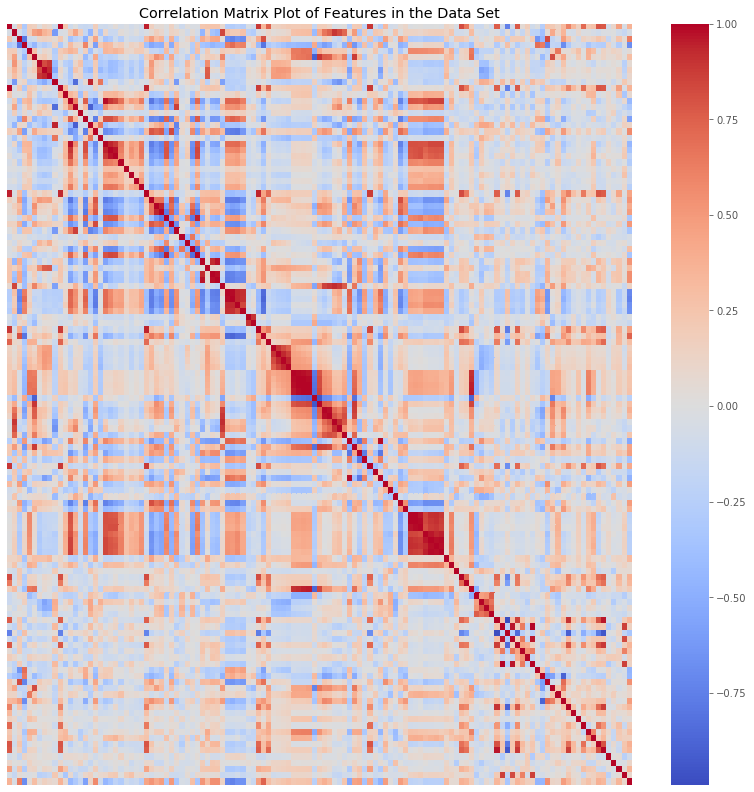

In [12]:
fit, axes = plt.subplots(figsize=(14, 14))
sns.heatmap(communities.corr(), cmap='coolwarm', xticklabels=False, yticklabels=False, ax=axes)
plt.title("Correlation Matrix Plot of Features in the Data Set")
plt.show()

### 1(d) Calculate the Coefficient of Variation CV for each feature, where CV = s , in which s is sample standard deviation and m is sample mean..

In [13]:
CV = communities.apply(lambda attrs : attrs.std() / attrs.mean(), axis=0)
CV

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.306251
LemasGangUnitDeploy    0.921372
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.844368
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64

### 1(e) pick sqrt(128) features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [14]:
num_features = int(math.sqrt(128))
high_CV = CV.sort_values(ascending=False)[:num_features]
high_CV

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
LemasSwornFT           1.984599
PctPolicAsian          1.979371
HousVacant             1.958780
dtype: float64

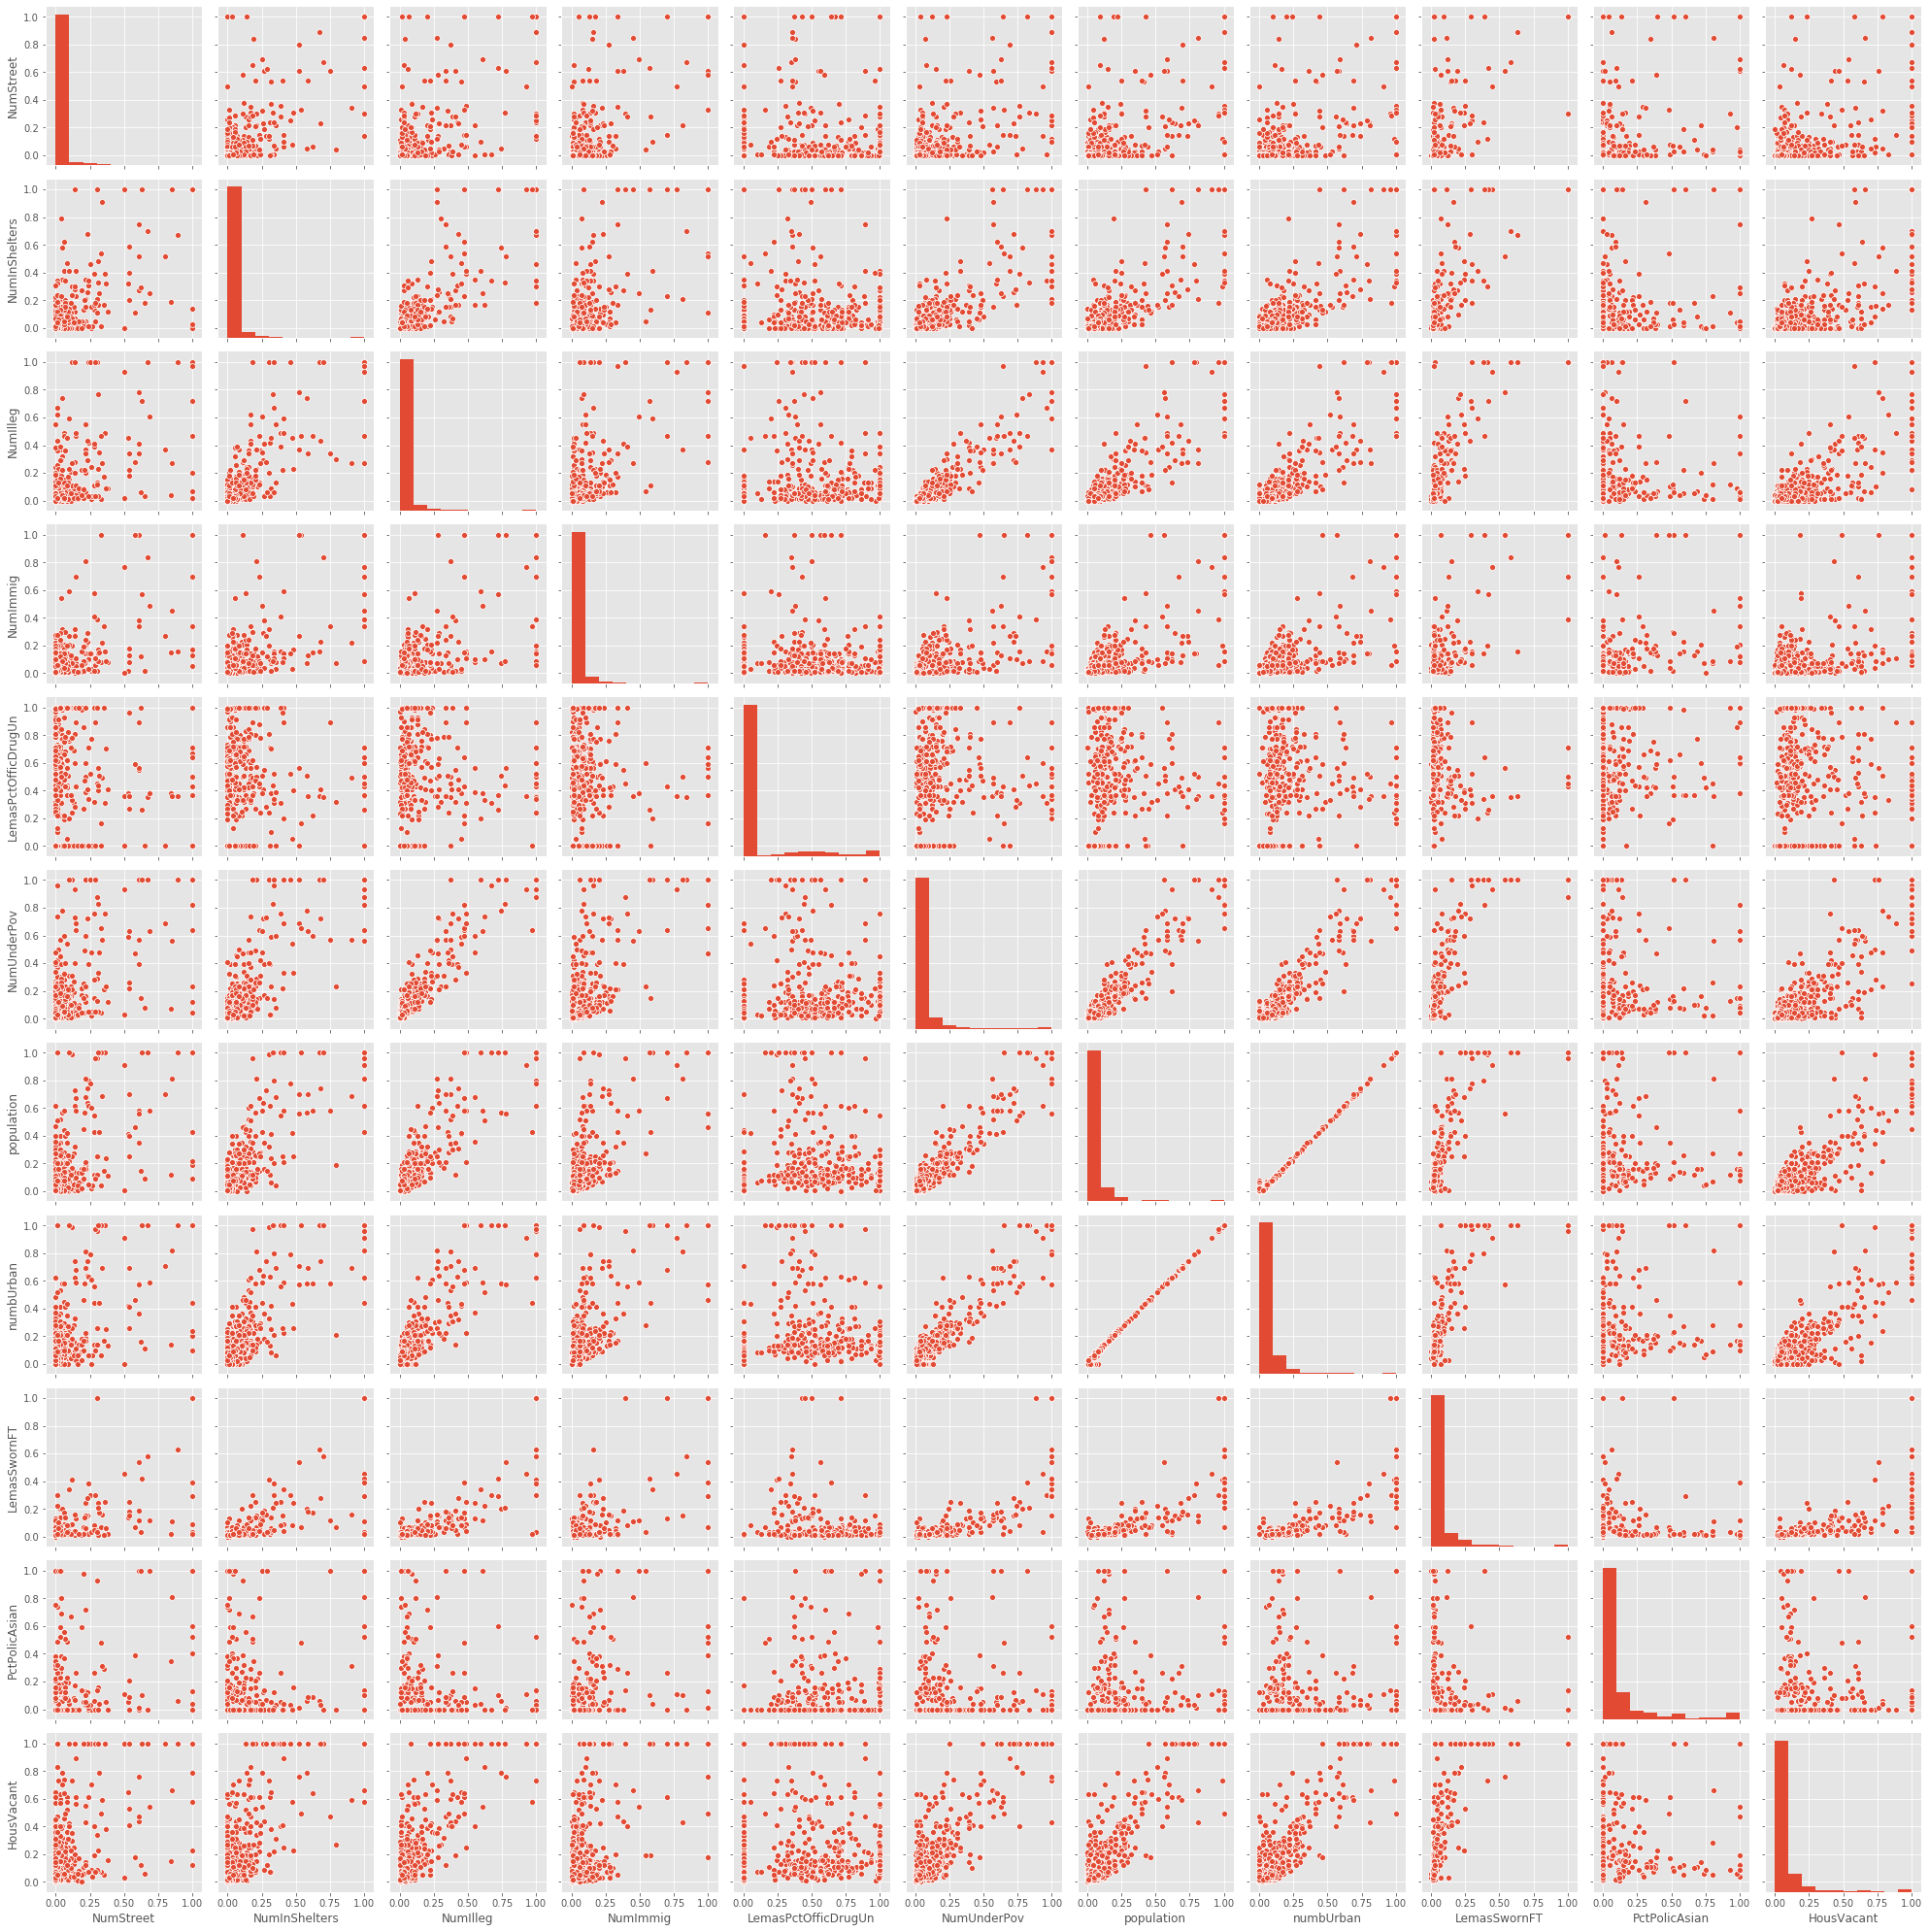

In [15]:
sns.pairplot(communities[high_CV.index.tolist()])
plt.show()

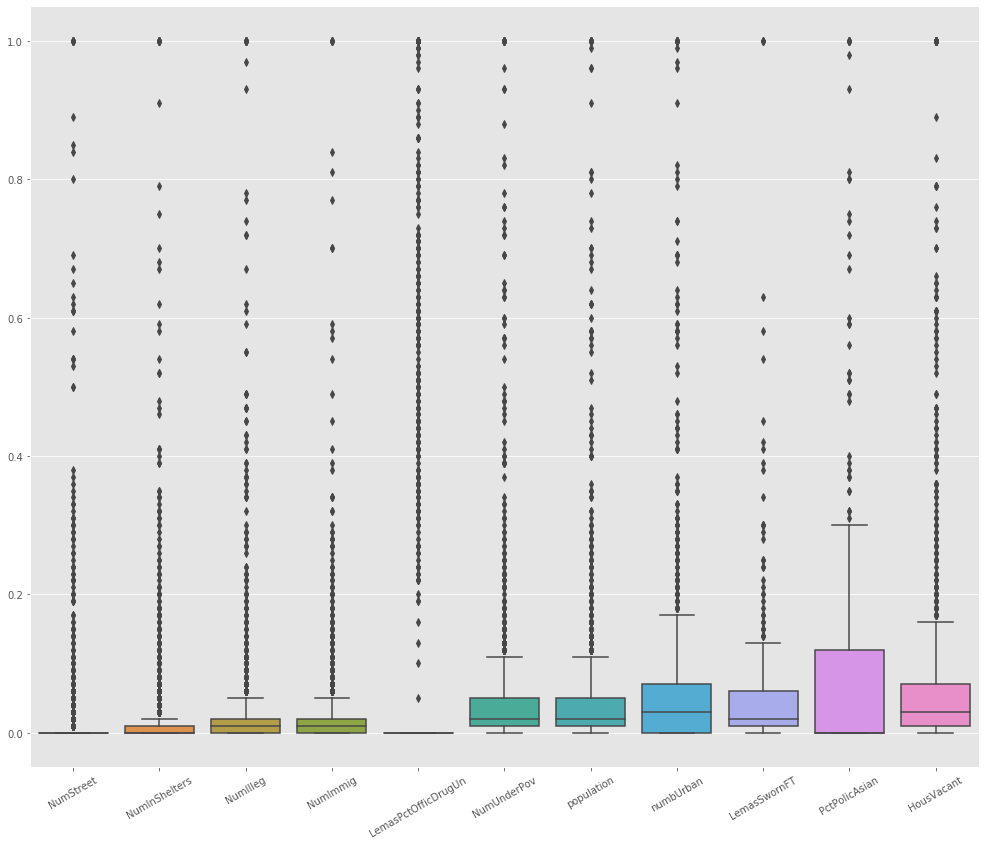

In [16]:
fig, axes = plt.subplots(figsize=(17, 14))
sns.boxplot(data = communities[high_CV.index.tolist()], ax = axes)
plt.xticks(rotation=30)
plt.show()

### It's hard to draw a conclusion about the significance of those features just by scatter plots. There is not a clear pattern in the scatter plot. We can only see the approximate relationship between the features by the scatter plots.

### 1(f) Fit a linear model using least squares to the training set and report the test error.

In [17]:
train_X = train_com.iloc[:, :-1]
train_Y = train_com.iloc[:, -1]

test_X = test_com.iloc[:, :-1]
test_Y = test_com.iloc[:, -1]

lreg = LinearRegression()
lreg.fit(train_X, train_Y)
test_pred = lreg.predict(test_X)
ols_test_mse = mean_squared_error(test_Y, test_pred)
print("OLS Linear Regression's test MSE:", ols_test_mse)

OLS Linear Regression's test MSE: 0.017844644706157813


### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [18]:
splitter = KFold(5, shuffle=True, random_state=1495)

alphas = [10 ** i for i in range(-5, 6)]

ridge_model = RidgeCV(alphas = alphas, cv = splitter, scoring='neg_mean_squared_error')
ridge_model.fit(train_X, train_Y)
print("Choose alpha: {}".format(ridge_model.alpha_))

Choose alpha: 1.0


In [19]:
test_pred = ridge_model.predict(test_X)
ridge_reg_test_mse = mean_squared_error(test_Y, test_pred)
print("Ridge Regression's test MSE:", ridge_reg_test_mse)

Ridge Regression's test MSE: 0.017502306931091567


### 1(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized2 features. Report the test error for both cases and compare them.

In [20]:
lasso_model = LassoCV(alphas = alphas, cv = splitter)
lasso_model.fit(train_X, train_Y)
print("Choose alpha: {}".format(lasso_model.alpha_))

Choose alpha: 0.0001


In [21]:
test_pred = lasso_model.predict(test_X)
lasso_test_mse = mean_squared_error(test_Y, test_pred)
print("Lasso Regression (no standardization)'s test MSE:", lasso_test_mse)
lasso_selecte_feature = pd.Series(data = lasso_model.coef_[lasso_model.coef_!=0],
                                  index = test_X.columns[lasso_model.coef_!=0])
lasso_selecte_feature

Lasso Regression (no standardization)'s test MSE: 0.017583852219939775


racepctblack           0.275387
racePctAsian          -0.014810
agePct12t21            0.078213
agePct12t29           -0.279285
agePct65up             0.011939
                         ...   
PctSameCity85          0.028100
LandArea               0.016662
PopDens                0.007536
PctUsePubTrans        -0.046075
LemasPctOfficDrugUn    0.009125
Length: 67, dtype: float64

In [22]:
# standardization
scaler = StandardScaler()
std_train_X = scaler.fit_transform(train_X)
std_test_X = scaler.fit_transform(test_X)
std_train_X = pd.DataFrame(data=std_train_X, columns=train_X.columns)
std_test_X = pd.DataFrame(data=std_test_X, columns=test_X.columns)

lasso_model = LassoCV(alphas = alphas, cv = splitter)
lasso_model.fit(std_train_X, train_Y)
print("Choose alpha: {}".format(lasso_model.alpha_))

Choose alpha: 0.001


In [23]:
test_pred = lasso_model.predict(std_test_X)
lasso_std_test_mse = mean_squared_error(test_Y, test_pred)
print("Lasso Regression (with standardization)'s test MSE:", lasso_std_test_mse)
lasso_selecte_feature = pd.Series(data=lasso_model.coef_[lasso_model.coef_!=0],
                                  index=test_X.columns[lasso_model.coef_!=0])
print(lasso_selecte_feature)

Lasso Regression (with standardization)'s test MSE: 0.017710939343910607
population              -0.001318
racepctblack             0.067537
agePct12t21              0.005808
agePct12t29             -0.027356
pctUrban                 0.015397
pctWWage                -0.009828
pctWFarmSelf             0.003414
pctWInvInc              -0.015813
pctWSocSec               0.005282
pctWPubAsst              0.003295
pctWRetire              -0.014889
whitePerCap             -0.004651
blackPerCap             -0.003123
indianPerCap            -0.005016
AsianPerCap              0.004814
OtherPerCap              0.003792
HispPerCap               0.002939
PctPopUnderPov          -0.021052
PctLess9thGrade         -0.000525
PctEmploy                0.015509
MalePctDivorce           0.016556
MalePctNevMarr           0.015150
FemalePctDiv            -0.001859
PctKids2Par             -0.041631
PctYoungKids2Par        -0.008787
PctTeen2Par             -0.000512
PctWorkMom              -0.020014
NumIlleg 

### The test error of the lasso regression without standardization is 0.01758385221993978; the test error of the lasso regression with standardization is 0.017710939343910607. The test error of the regression with standardization is slightly lower.

### 1(i) Fit a PCR model on the training set, with M (the number of principal compo- nents) chosen by cross-validation. Report the test error obtained.

In [24]:
def PCR(train_X, train_Y, fold, dim):
    valid_err = 0
    splitter = KFold(fold, shuffle=True, random_state=1495)
    
    for train_idx, valid_idx in splitter.split(train_X):
        trainX = train_X.iloc[train_idx, :]
        trainY = train_Y.iloc[train_idx]
        validX = train_X.iloc[valid_idx, :]
        validY = train_Y.iloc[valid_idx]

        pca = PCA(n_components=dim).fit(trainX)
        pca_train = pca.transform(trainX)
        pca_valid = pca.transform(validX)

        lreg = LinearRegression()
        lreg.fit(pca_train, trainY)
        valid_pred = lreg.predict(pca_valid)
        valid_mse = mean_squared_error(validY, valid_pred)

        valid_err += valid_mse
    return valid_err / fold

valid_err_mean = []

for m in range(1, len(train_X.columns) + 1):
    valid_err = PCR(train_X, train_Y, 5, m)
    valid_err_mean.append((m, valid_err))

# sort the list and get the minimum validation error
valid_err_mean.sort(key=lambda x: x[1])
valid_err_mean

[(87, 0.0192285225571209),
 (88, 0.019229309160934155),
 (86, 0.019243519043315373),
 (83, 0.01925584964016071),
 (84, 0.019274774027064984),
 (85, 0.019287512838006587),
 (89, 0.01930759243769614),
 (90, 0.01939075431958633),
 (82, 0.019406174624989912),
 (92, 0.019419493214653357),
 (81, 0.01943373303910592),
 (75, 0.01943817171041222),
 (91, 0.01944048323214984),
 (76, 0.019457703808668757),
 (80, 0.019467575035207893),
 (79, 0.01946808203047919),
 (77, 0.019493331028509843),
 (78, 0.01949341415719877),
 (93, 0.01953786081647165),
 (95, 0.019554812917243397),
 (94, 0.019556024894881927),
 (96, 0.019576138564297112),
 (97, 0.019579626293028587),
 (98, 0.019598241843593017),
 (100, 0.01960636482728825),
 (99, 0.019621785618790542),
 (74, 0.019721813732259636),
 (58, 0.01973872319997124),
 (61, 0.019746905258479115),
 (63, 0.019747569954416153),
 (62, 0.019750942877797634),
 (57, 0.019750951832569346),
 (64, 0.01976652987144054),
 (52, 0.019786390005642245),
 (56, 0.019793726360390264)

### The minimum validation mse is 0.019228522557120896. The corresponding M = 87

In [25]:
# Using the best M to create a PCA model
pca = PCA(n_components=87).fit(train_X)
pca_train = pca.transform(train_X)
pca_test = pca.transform(test_X)
lreg = LinearRegression().fit(pca_train, train_Y)
test_pred = lreg.predict(pca_test)
pcr_test_mse = mean_squared_error(test_Y, test_pred)
print("PCR model's test MSE:", pcr_test_mse)

PCR model's test MSE: 0.017874126495056476


### 1(j) In this section, we would like to fit a boosting tree to the data.

In [26]:
avg_valid_err = []
alphas = [10 ** i for i in range(-10, 11)]

splitter = KFold(5, shuffle=True, random_state=1495)

for alpha in alphas:

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", reg_alpha=alpha)
    cvres = cross_val_score(xgb_model, train_X, train_Y, cv=splitter, scoring="neg_mean_squared_error")
    avg_valid_err.append((alpha, np.abs(cvres.mean())))

avg_valid_err.sort(key=lambda x: x[1])
print("When alpha = {}, the validation mse reaches minimum of {}.".format(avg_valid_err[0][0], avg_valid_err[0][1]))

When alpha = 1, the validation mse reaches minimum of 0.02200590191871861.


### The minimum validation mse is 0.020373637387641738. The corresponding alpha = 0.1

In [27]:
# xgboost model with best value of alpha
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=0.1).fit(train_X, train_Y)
test_pred = xgb_model.predict(test_X)
xgb_test_mse = mean_squared_error(test_Y, test_pred)
print("XGBoost model's test MSE:", xgb_test_mse)


XGBoost model's test MSE: 0.017677356692014548


## 2. Tree-Based Methods

### 2(a) Download the APS Failure data

In [28]:
train_aps = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20, na_values = 'na')
test_aps = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20, na_values = 'na')
all_aps = pd.concat([train_aps, test_aps])

In [29]:
train_aps

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1       neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2       neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3       neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4       neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
59995   neg  153002     NaN  6.640000e+02   186.0     0.0     0.0     0.0   
59996   neg    2286     NaN  2.130707e+09   224.0     0.0     0.0     0.0   
59997   neg     112     0.0  2.130706e+09    18.0     0.0     0.0     0.0   
59998   neg   80292     NaN  2.130706e+09   494.0     0.0     0.0     0.0   
59999   neg   40222     NaN  6.980000e+02   628.0     0.0     0.0     0.0   

       ag_001  ag_002  ...     ee_002    ee_003     ee_004     ee_005  \
0         0.0     0.0  ...  1240520.0  493384.0   721044.0   469792.0   
1         0.0     0.0  ...   421400.0  178064.0   293306.0   245416.0   
2         0.0     0.0  ...   277378.0  159812.0   423992.0   409564.0   
3         0.0     0.0  ...      240.0      46.0       58.0       44.0   
4         0.0     0.0  ...   622012.0  229790.0   405298.0   347188.0   
...       ...     ...  ...        ...       ...        ...        ...   
59995     0.0     0.0  ...   998500.0  566884.0  1290398.0  1218244.0   
59996     0.0     0.0  ...    10578.0    6760.0    21126.0    68424.0   
59997     0.0     0.0  ...      792.0     386.0      452.0      144.0   
59998     0.0     0.0  ...   699352.0  222654.0   347378.0   225724.0   
59999     0.0     0.0  ...   440066.0  183200.0   344546.0   254068.0   

          ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  
0       339156.0  157956.0   73224.0       0.0     0.0     0.0  
1       133654.0   81140.0   97576.0    1500.0     0.0     0.0  
2       320746.0  158022.0   95128.0     514.0     0.0     0.0  
3           10.0       0.0       0.0       0.0     4.0    32.0  
4       286954.0  311560.0  433954.0    1218.0     0.0     0.0  
...          ...       ...       ...       ...     ...     ...  
59995  1019768.0  717762.0  898642.0   28588.0     0.0     0.0  
59996      136.0       0.0       0.0       0.0     0.0     0.0  
59997      146.0    2622.0       0.0       0.0     0.0     0.0  
59998   194440.0  165070.0  802280.0  388422.0     0.0     0.0  
59999   225148.0  158304.0  170384.0     158.0     0.0     0.0  

[60000 rows x 171 columns]

In [30]:
test_aps

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0       neg      60     0.0  2.000000e+01    12.0     0.0     0.0     0.0   
1       neg      82     0.0  6.800000e+01    40.0     0.0     0.0     0.0   
2       neg   66002     2.0  2.120000e+02   112.0     0.0     0.0     0.0   
3       neg   59816     NaN  1.010000e+03   936.0     0.0     0.0     0.0   
4       neg    1814     NaN  1.560000e+02   140.0     0.0     0.0     0.0   
...     ...     ...     ...           ...     ...     ...     ...     ...   
15995   neg   81852     NaN  2.130706e+09   892.0     0.0     0.0     0.0   
15996   neg      18     0.0  5.200000e+01    46.0     8.0    26.0     0.0   
15997   neg   79636     NaN  1.670000e+03  1518.0     0.0     0.0     0.0   
15998   neg     110     NaN  3.600000e+01    32.0     0.0     0.0     0.0   
15999   neg       8     0.0  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002  ...    ee_002    ee_003    ee_004    ee_005     ee_006  \
0         0.0     0.0  ...    1098.0     138.0     412.0     654.0       78.0   
1         0.0     0.0  ...    1068.0     276.0    1620.0     116.0       86.0   
2         0.0     0.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0   
3         0.0     0.0  ...  540820.0  243270.0  483302.0  485332.0   431376.0   
4         0.0     0.0  ...    7646.0    4144.0   18466.0   49782.0     3176.0   
...       ...     ...  ...       ...       ...       ...       ...        ...   
15995     0.0     0.0  ...  632658.0  273242.0  510354.0  373918.0   349840.0   
15996     0.0     0.0  ...     266.0      44.0      46.0      14.0        2.0   
15997     0.0     0.0  ...  806832.0  449962.0  778826.0  581558.0   375498.0   
15998     0.0     0.0  ...     588.0     210.0     180.0     544.0     1004.0   
15999     0.0     0.0  ...      46.0      10.0      48.0      14.0       42.0   

         ee_007    ee_008   ee_009  ef_000  eg_000  
0          88.0       0.0      0.0     0.0     0.0  
1         462.0       0.0      0.0     0.0     0.0  
2      153680.0     516.0      0.0     0.0     0.0  
3      210074.0  281662.0   3232.0     0.0     0.0  
4         482.0      76.0      0.0     0.0     0.0  
...         ...       ...      ...     ...     ...  
15995  317840.0  960024.0  25566.0     0.0     0.0  
15996       0.0       0.0      0.0     0.0     0.0  
15997  222866.0  358934.0  19548.0     0.0     0.0  
15998    1338.0      74.0      0.0     0.0     0.0  
15999      46.0       0.0      0.0     0.0     0.0  

[16000 rows x 171 columns]

## 2(b)i. Research what types of techniques are usually used for dealing with data with missing values.5 Pick at least one of them and apply it to this data in the next steps.

#### There are mainly two types of imputation: univariant and multivariant.
#### Univariant imputation imputes values in the i-th feature dimension using only non-missing values in that feature dimension. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located.
#### By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values. It uses the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation.

In [31]:
train_aps_X = train_aps.iloc[:, 1:]
train_aps_Y = train_aps.iloc[:, 0]
test_aps_X = test_aps.iloc[:, 1:]
test_aps_Y = test_aps.iloc[:, 0]

In [32]:
imputation_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train_aps_X = pd.DataFrame(imputation_mean.fit_transform(train_aps_X), columns = train_aps.columns[1:])
test_aps_X = pd.DataFrame(imputation_mean.fit_transform(test_aps_X), columns = test_aps.columns[1:])

In [33]:
train_aps_X

aa_000    ab_000        ac_000         ad_000  ae_000  af_000  \
0       76698.0  0.713189  2.130706e+09     280.000000     0.0     0.0   
1       33058.0  0.713189  0.000000e+00  190620.639314     0.0     0.0   
2       41040.0  0.713189  2.280000e+02     100.000000     0.0     0.0   
3          12.0  0.000000  7.000000e+01      66.000000     0.0    10.0   
4       60874.0  0.713189  1.368000e+03     458.000000     0.0     0.0   
...         ...       ...           ...            ...     ...     ...   
59995  153002.0  0.713189  6.640000e+02     186.000000     0.0     0.0   
59996    2286.0  0.713189  2.130707e+09     224.000000     0.0     0.0   
59997     112.0  0.000000  2.130706e+09      18.000000     0.0     0.0   
59998   80292.0  0.713189  2.130706e+09     494.000000     0.0     0.0   
59999   40222.0  0.713189  6.980000e+02     628.000000     0.0     0.0   

       ag_000  ag_001  ag_002  ag_003  ...     ee_002    ee_003     ee_004  \
0         0.0     0.0     0.0     0.0  ...  1240520.0  493384.0   721044.0   
1         0.0     0.0     0.0     0.0  ...   421400.0  178064.0   293306.0   
2         0.0     0.0     0.0     0.0  ...   277378.0  159812.0   423992.0   
3         0.0     0.0     0.0   318.0  ...      240.0      46.0       58.0   
4         0.0     0.0     0.0     0.0  ...   622012.0  229790.0   405298.0   
...       ...     ...     ...     ...  ...        ...       ...        ...   
59995     0.0     0.0     0.0  2564.0  ...   998500.0  566884.0  1290398.0   
59996     0.0     0.0     0.0     0.0  ...    10578.0    6760.0    21126.0   
59997     0.0     0.0     0.0     0.0  ...      792.0     386.0      452.0   
59998     0.0     0.0     0.0     0.0  ...   699352.0  222654.0   347378.0   
59999     0.0     0.0     0.0     0.0  ...   440066.0  183200.0   344546.0   

          ee_005     ee_006    ee_007    ee_008    ee_009  ef_000  eg_000  
0       469792.0   339156.0  157956.0   73224.0       0.0     0.0     0.0  
1       245416.0   133654.0   81140.0   97576.0    1500.0     0.0     0.0  
2       409564.0   320746.0  158022.0   95128.0     514.0     0.0     0.0  
3           44.0       10.0       0.0       0.0       0.0     4.0    32.0  
4       347188.0   286954.0  311560.0  433954.0    1218.0     0.0     0.0  
...          ...        ...       ...       ...       ...     ...     ...  
59995  1218244.0  1019768.0  717762.0  898642.0   28588.0     0.0     0.0  
59996    68424.0      136.0       0.0       0.0       0.0     0.0     0.0  
59997      144.0      146.0    2622.0       0.0       0.0     0.0     0.0  
59998   225724.0   194440.0  165070.0  802280.0  388422.0     0.0     0.0  
59999   254068.0   225148.0  158304.0  170384.0     158.0     0.0     0.0  

[60000 rows x 170 columns]

In [34]:
test_aps_X

aa_000    ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0         60.0  0.000000  2.000000e+01    12.0     0.0     0.0     0.0   
1         82.0  0.000000  6.800000e+01    40.0     0.0     0.0     0.0   
2      66002.0  2.000000  2.120000e+02   112.0     0.0     0.0     0.0   
3      59816.0  0.772065  1.010000e+03   936.0     0.0     0.0     0.0   
4       1814.0  0.772065  1.560000e+02   140.0     0.0     0.0     0.0   
...        ...       ...           ...     ...     ...     ...     ...   
15995  81852.0  0.772065  2.130706e+09   892.0     0.0     0.0     0.0   
15996     18.0  0.000000  5.200000e+01    46.0     8.0    26.0     0.0   
15997  79636.0  0.772065  1.670000e+03  1518.0     0.0     0.0     0.0   
15998    110.0  0.772065  3.600000e+01    32.0     0.0     0.0     0.0   
15999      8.0  0.000000  6.000000e+00     4.0     2.0     2.0     0.0   

       ag_001  ag_002    ag_003  ...    ee_002    ee_003    ee_004    ee_005  \
0         0.0     0.0    2682.0  ...    1098.0     138.0     412.0     654.0   
1         0.0     0.0       0.0  ...    1068.0     276.0    1620.0     116.0   
2         0.0     0.0  199486.0  ...  495076.0  380368.0  440134.0  269556.0   
3         0.0     0.0       0.0  ...  540820.0  243270.0  483302.0  485332.0   
4         0.0     0.0       0.0  ...    7646.0    4144.0   18466.0   49782.0   
...       ...     ...       ...  ...       ...       ...       ...       ...   
15995     0.0     0.0       0.0  ...  632658.0  273242.0  510354.0  373918.0   
15996     0.0     0.0       0.0  ...     266.0      44.0      46.0      14.0   
15997     0.0     0.0       0.0  ...  806832.0  449962.0  778826.0  581558.0   
15998     0.0     0.0       0.0  ...     588.0     210.0     180.0     544.0   
15999     0.0     0.0       0.0  ...      46.0      10.0      48.0      14.0   

          ee_006    ee_007    ee_008   ee_009  ef_000  eg_000  
0           78.0      88.0       0.0      0.0     0.0     0.0  
1           86.0     462.0       0.0      0.0     0.0     0.0  
2      1315022.0  153680.0     516.0      0.0     0.0     0.0  
3       431376.0  210074.0  281662.0   3232.0     0.0     0.0  
4         3176.0     482.0      76.0      0.0     0.0     0.0  
...          ...       ...       ...      ...     ...     ...  
15995   349840.0  317840.0  960024.0  25566.0     0.0     0.0  
15996        2.0       0.0       0.0      0.0     0.0     0.0  
15997   375498.0  222866.0  358934.0  19548.0     0.0     0.0  
15998     1004.0    1338.0      74.0      0.0     0.0     0.0  
15999       42.0      46.0       0.0      0.0     0.0     0.0  

[16000 rows x 170 columns]

### 2(b)ii. For each of the 170 features, calculate the coefficient of variation CV = s /m, where s is sample standard deviation and m is sample mean.

In [35]:
CV_aps = train_aps_X.apply(lambda attrs: np.abs(np.std(attrs) / np.mean(attrs)), axis=0)
CV_aps_feats = CV_aps.sort_values(ascending=False)[:170]
CV_aps_feats

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
             ...    
bo_000      0.462560
bp_000      0.425963
bq_000      0.399188
br_000      0.382666
cd_000      0.000000
Length: 170, dtype: float64

### 2(b)iii. Plot a correlation matrix for your features using pandas or any other tool.

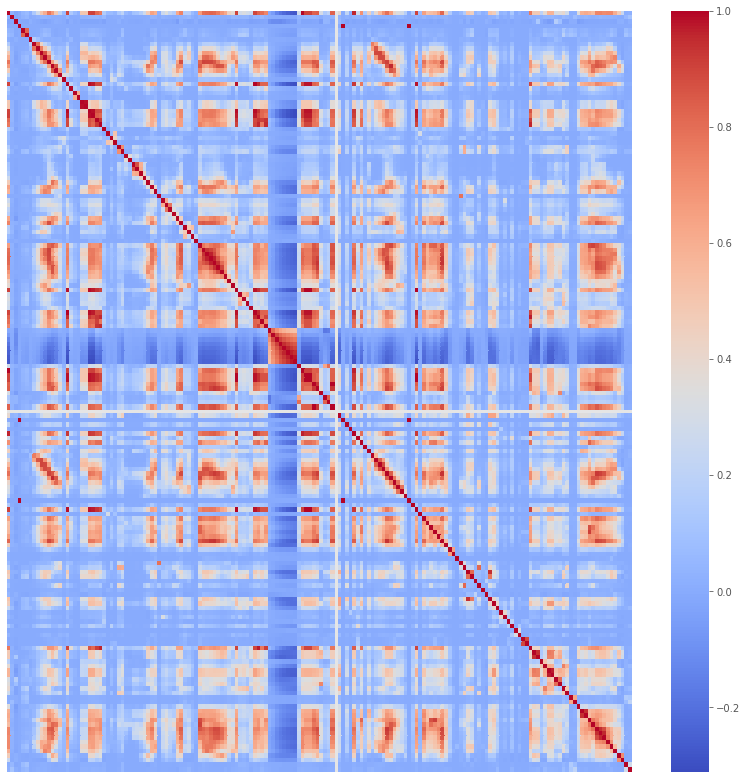

In [36]:
fit, axes = plt.subplots(figsize=(14, 14))
sns.heatmap(train_aps_X.corr(), cmap='coolwarm', xticklabels = False, yticklabels = False, ax = axes)
plt.show()

### 2(b)iv. Pick sqrt(170) features with highest CV , and make scatter plots and box plots

In [37]:
num_feats = int(math.sqrt(170))
CV_aps_feats = CV_aps.sort_values(ascending=False)[:num_feats]
CV_aps_feats

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
dj_000    109.646371
ag_000     91.877799
as_000     86.416184
ay_009     83.785365
az_009     76.967337
ak_000     74.526067
au_000     68.159986
ch_000     58.267743
dtype: float64

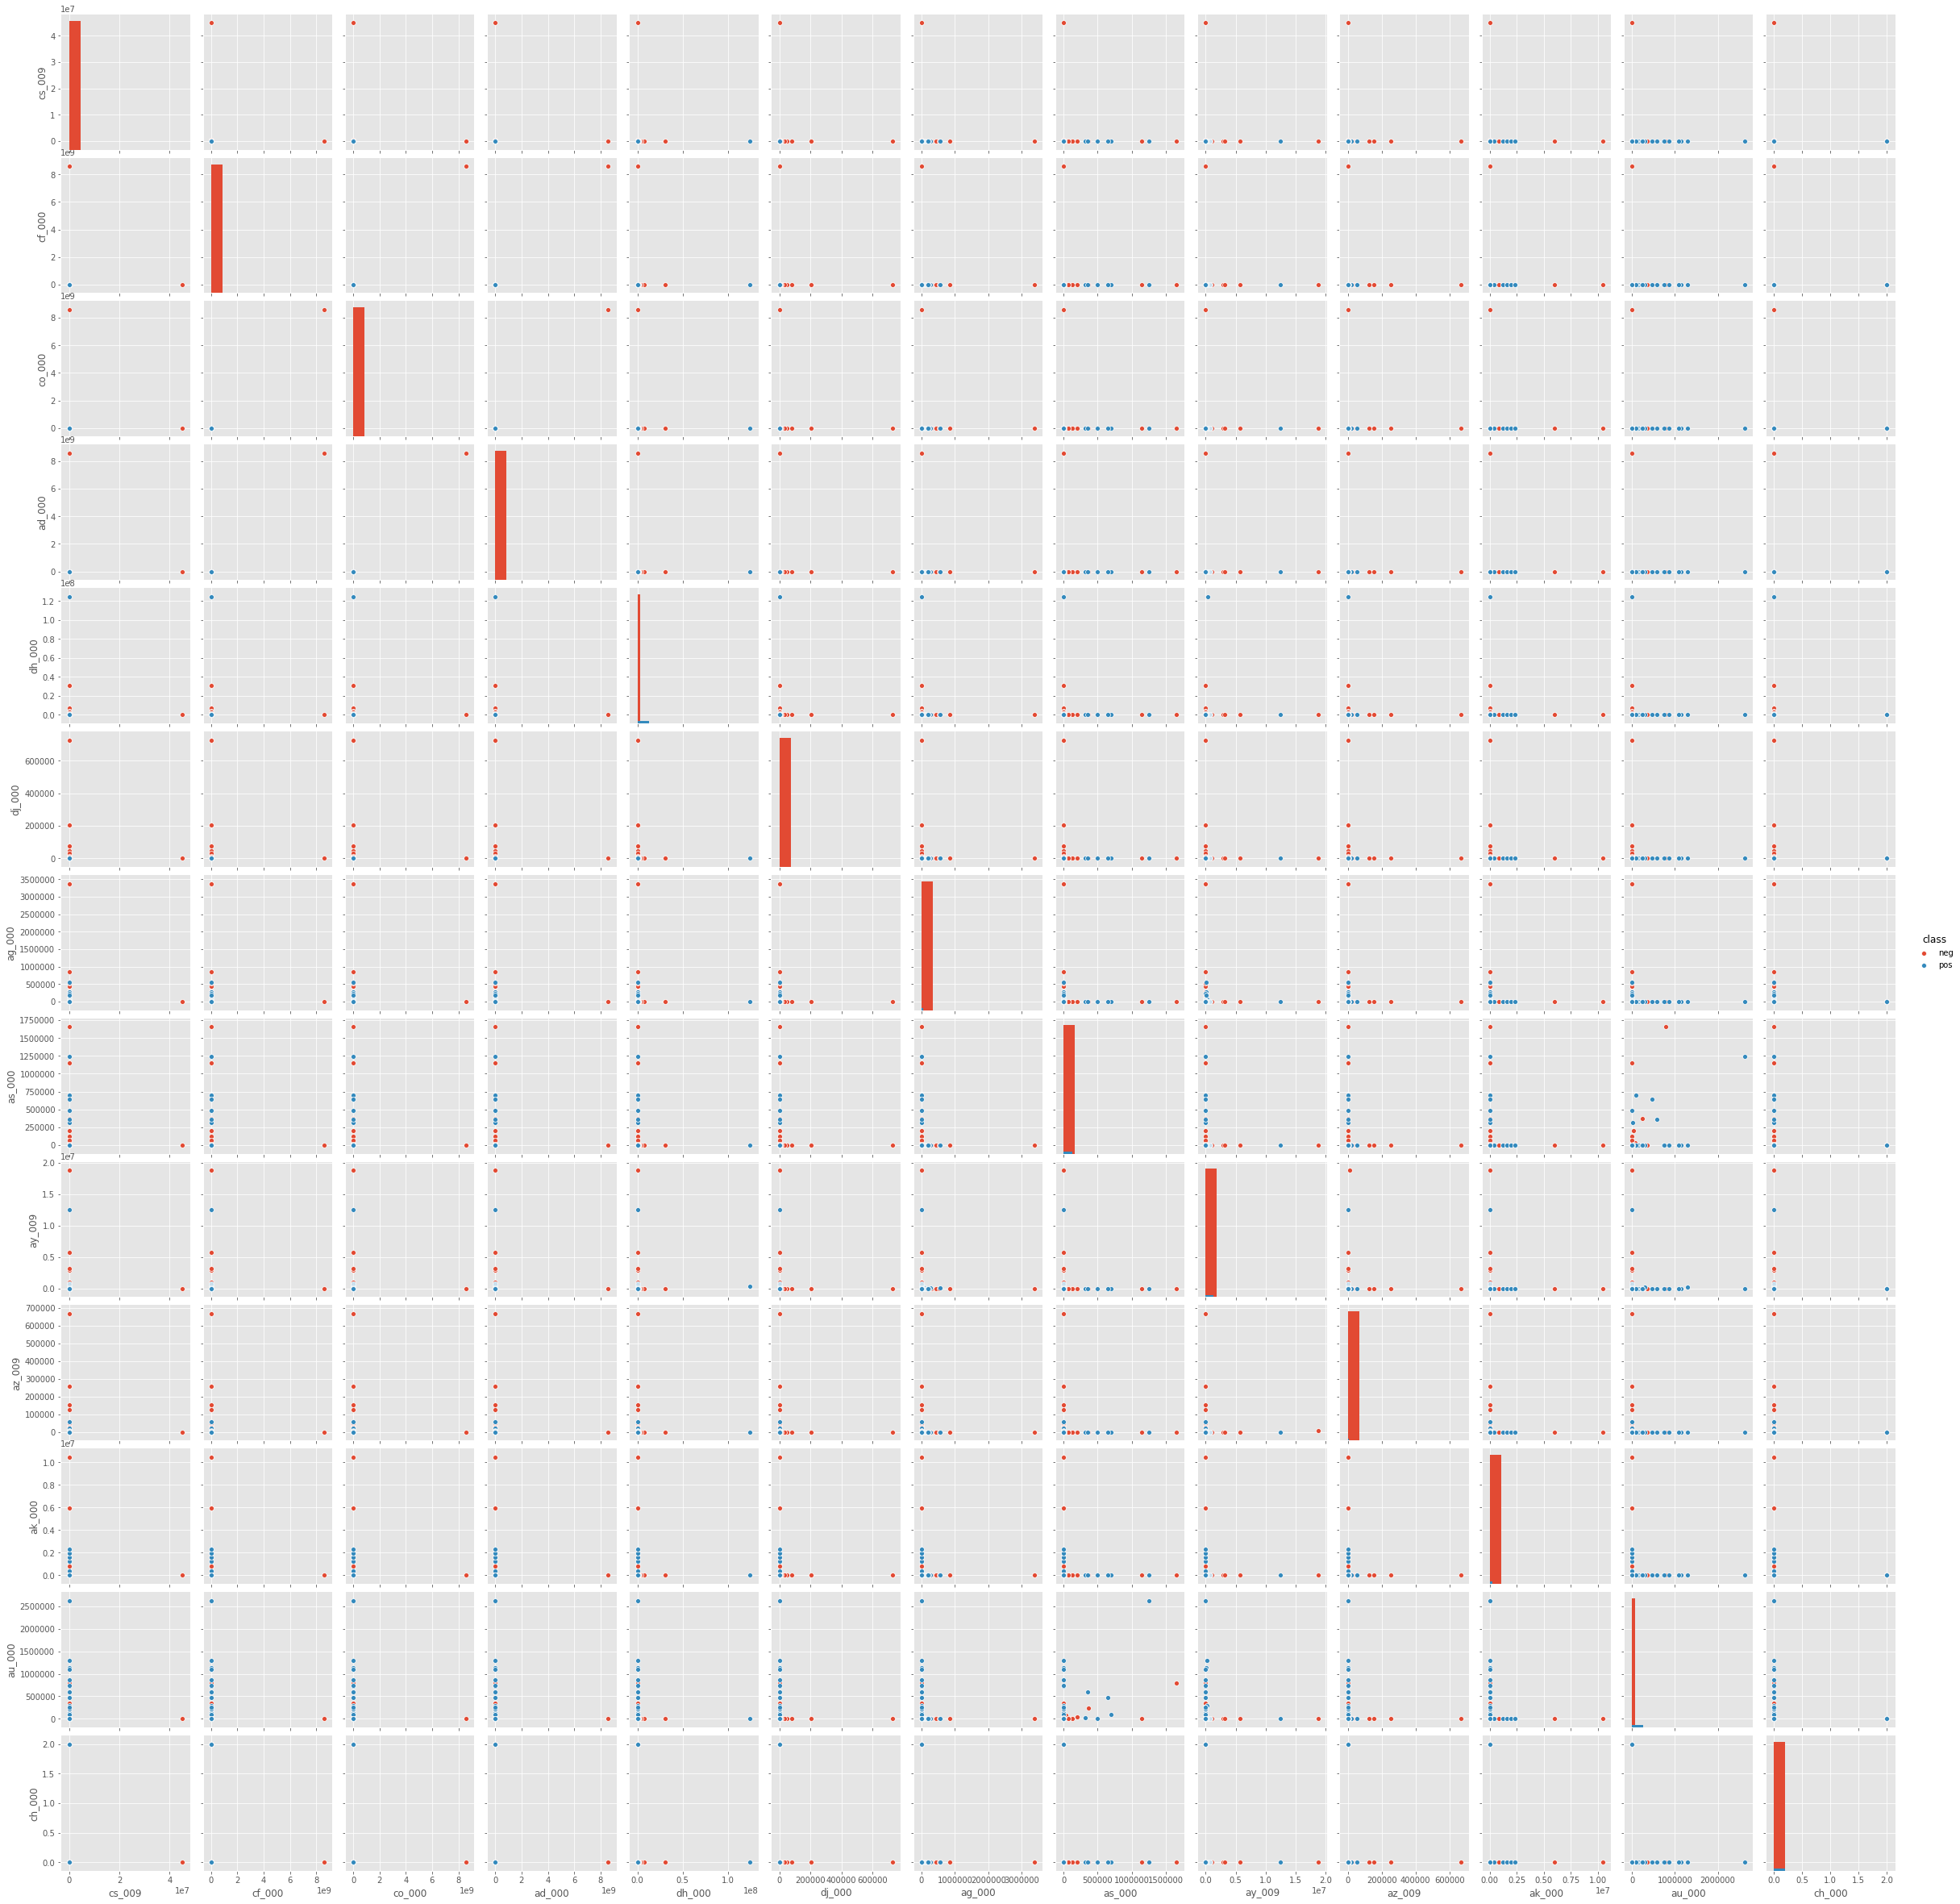

In [38]:
merged = train_aps_X[CV_aps_feats.index.to_list()].copy()
merged.loc[:, 'class'] = train_aps_Y
sns.pairplot(merged, hue='class', diag_kind='hist')
plt.show()

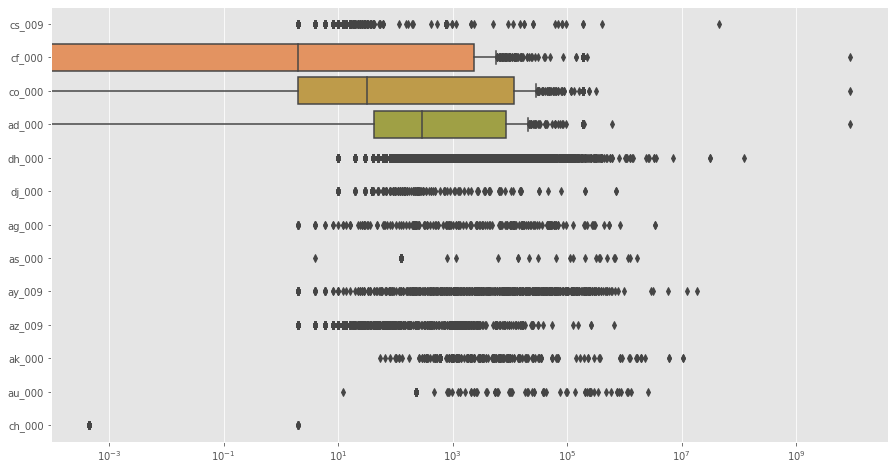

In [39]:
fig, axes = plt.subplots(figsize=(15, 8))
box = sns.boxplot(data = train_aps_X[CV_aps_feats.index.to_list()], orient='h', ax=axes)
box.set(xscale="log")
plt.show()

#### It's hard to draw any conclusions about the significance of the features through these dot plots and box plots.

In [40]:
train_aps_Y.value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [41]:
test_aps_Y.value_counts()

neg    15625
pos      375
Name: class, dtype: int64

#### Both the train set and the test set are imbalanced

### 2(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [42]:
def modelReport(ground_truth, predict, prob, title):
    conf_mat = confusion_matrix(ground_truth, predict)
    print("The confusion for {} set is \n{}".format(title, conf_mat))
    acc = accuracy_score(ground_truth, predict)
    print("The classification accuracy is %0.4f" % acc)
    fpr, tpr, thresholds = roc_curve(ground_truth, prob[:, 1], pos_label='pos')
    roc_auc = round(auc(fpr, tpr), 4)
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    axes.set_title("ROC curves of {} set".format(title))
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


The confusion for training set is 
[[58972    28]
 [  450   550]]
The classification accuracy is 0.9920


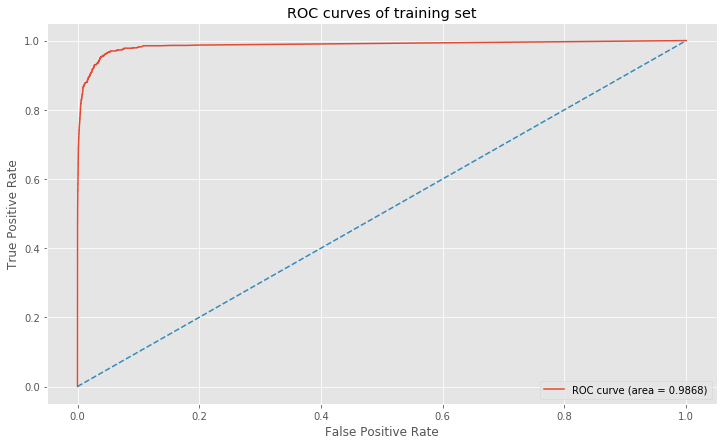

In [43]:
RF_model = RandomForestClassifier(max_depth=5, random_state=60000, verbose=1, oob_score=True)
RF_model.fit(train_aps_X, train_aps_Y)

train_Y_predict = RF_model.predict(train_aps_X)
train_Y_prob = RF_model.predict_proba(train_aps_X)

# get confusion matrix, ROC, AUC 
modelReport(train_aps_Y, train_Y_predict, train_Y_prob, 'training')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The confusion for test set is 
[[15612    13]
 [  180   195]]
The classification accuracy is 0.9879


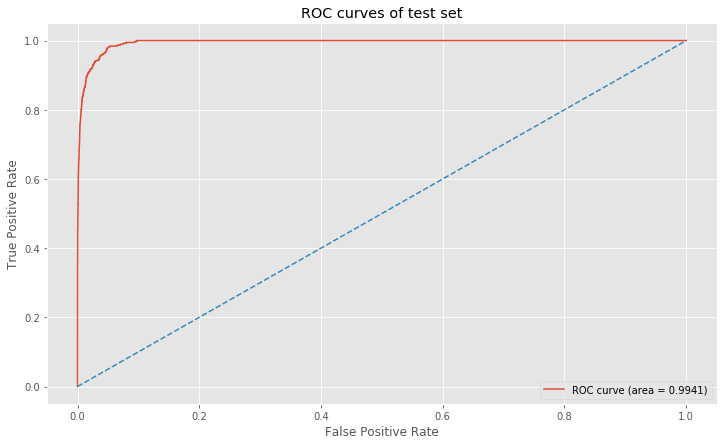

In [44]:
test_Y_predict = RF_model.predict(test_aps_X)
test_Y_prob = RF_model.predict_proba(test_aps_X)

# get confusion matrix, ROC, AUC 
modelReport(test_aps_Y, test_Y_predict, test_Y_prob, 'test')

In [45]:
trainOOB_err = round(1 - RF_model.oob_score_, 4)
print("Out of Bag Error of training set: %.4f"%trainOOB_err)
print("Test Error: %.4f"%round(1 - accuracy_score(test_aps_Y, test_Y_predict), 4))

Out of Bag Error of training set: 0.0094
Test Error: 0.0121


### 2(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


The confusion for training set is 
[[56563  2437]
 [   31   969]]
The classification accuracy is 0.9589


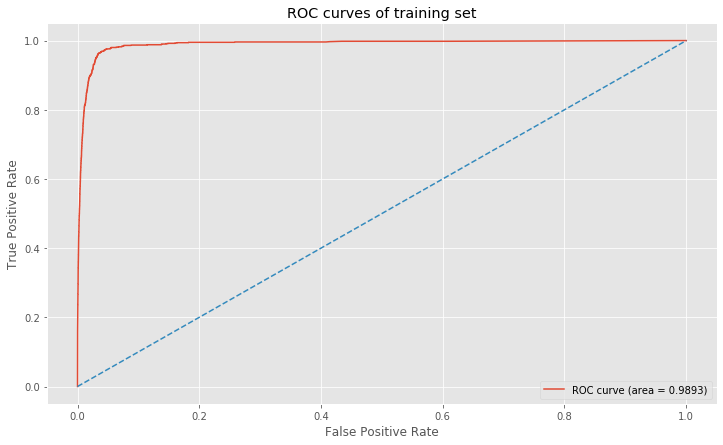

In [46]:
#balanced model
RF_model = RandomForestClassifier(max_depth=5, random_state=60000, verbose=1, oob_score=True, class_weight='balanced')
RF_model.fit(train_aps_X, train_aps_Y)

train_Y_predict = RF_model.predict(train_aps_X)
train_Y_prob = RF_model.predict_proba(train_aps_X)

modelReport(train_aps_Y, train_Y_predict, train_Y_prob, 'training')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


The confusion for test set is 
[[14992   633]
 [   15   360]]
The classification accuracy is 0.9595


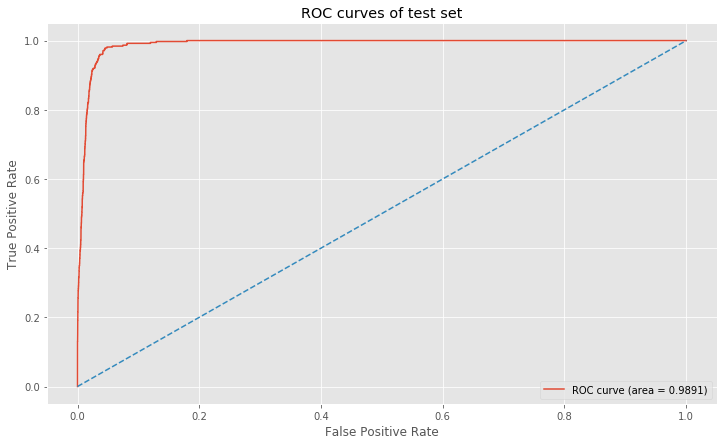

In [47]:
test_Y_predict = RF_model.predict(test_aps_X)
test_Y_prob = RF_model.predict_proba(test_aps_X)

modelReport(test_aps_Y, test_Y_predict, test_Y_prob, 'test')

In [48]:
trainOOB_err_balanced = round(1 - RF_model.oob_score_, 4)
print("The Out of Bag Error of training set is %.4f"%trainOOB_err_balanced)
print("The test Error is %.4f"%round(1 - accuracy_score(test_aps_Y, test_Y_predict), 4))

The Out of Bag Error of training set is 0.0424
The test Error is 0.0405


### The model without compensation has a better overall performance than the one that with compensation. The model building on a highly unbalanced data tend to classify data points to negative. Therefore, the accuracy is higher. However, it has a low TPR, which means that the model cannot classify positive datapoints well.

### 2(e) Model Trees

In [49]:
aps_train_new = train_aps_X.copy()
aps_train_new.loc[:, 'class'] = train_aps_Y
aps_test_new = test_aps_X.copy()
aps_test_new.loc[:, 'class'] = test_aps_Y

aps_train_new.to_csv('../data/weka_train.csv', index=False)
aps_test_new.to_csv('../data/weka_test.csv', index=False)

In [50]:
# load data and specify the column of label
weka_loader = Loader(classname="weka.core.converters.CSVLoader")
weka_train = weka_loader.load_file('../data/weka_train.csv')
weka_test = weka_loader.load_file('../data/weka_test.csv')
weka_train.class_is_last()
weka_test.class_is_last()

In [51]:
# 5-fold validation on training set
lmt = Classifier(classname = 'weka.classifiers.trees.LMT')
weka_evl = Evaluation(weka_train)
weka_evl.crossvalidate_model(classifier = lmt, data = weka_train, num_folds = 5, rnd=Random(60000))

In [52]:
weka_evl.confusion_matrix

array([[58823.,   177.],
       [  304.,   696.]])

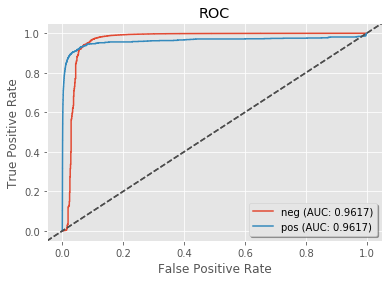

In [53]:
plcls.plot_roc(weka_evl, class_index=[0, 1], wait=True)

In [54]:
print(weka_evl.summary())
print(weka_evl.class_details())


Correctly Classified Instances       59519               99.1983 %
Incorrectly Classified Instances       481                0.8017 %
Kappa statistic                          0.7391
Mean absolute error                      0.011 
Root mean squared error                  0.0821
Relative absolute error                 33.5878 %
Root relative squared error             64.1084 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.304    0.995      0.997    0.996      0.741    0.962     0.998     neg
                 0.696    0.003    0.797      0.696    0.743      0.741    0.962     0.741     pos
Weighted Avg.    0.992    0.299    0.992      0.992    0.992      0.741    0.962     0.993     



In [55]:
# weka lmt model on test set
lmt.build_classifier(weka_train)

In [56]:
weka_test_predict = []
weka_test_proba = []

for i in weka_test:
    weka_test_predict.append(lmt.classify_instance(i))
    weka_test_proba.append(lmt.distribution_for_instance(i))

weka_test_predict = np.array(weka_test_predict).astype('str')
weka_test_predict[weka_test_predict == '0.0'] = 'neg'
weka_test_predict[weka_test_predict == '1.0'] = 'pos'
weka_test_proba = np.array(weka_test_proba)

The confusion for test set is 
[[15579    46]
 [  108   267]]
The classification accuracy is 0.9904


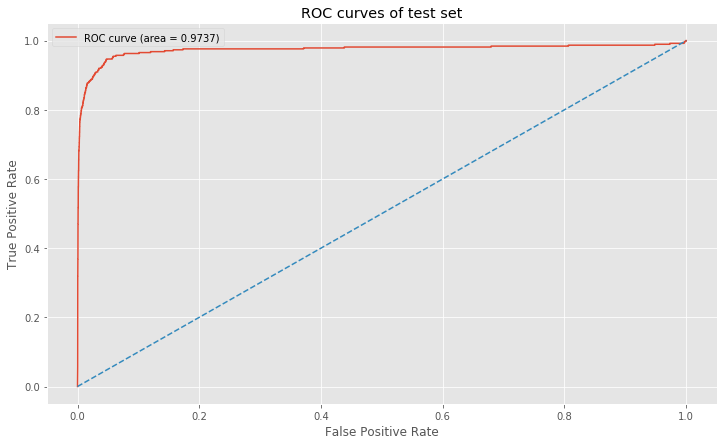

In [57]:
modelReport(test_aps_Y, weka_test_predict, weka_test_proba, 'test')

### 2(f) SMOTE

In [60]:
valid_err = []
splitter = StratifiedKFold(n_splits=5, random_state=60000, shuffle=True)
for train_idx, valid_idx in splitter.split(train_aps_X, train_aps_Y):
    cur_train_X = train_aps_X.iloc[train_idx, :]
    cur_train_Y = train_aps_Y.iloc[train_idx]
    bi_cur_train_Y = cur_train_Y.replace({'neg' : 0.0, 'pos' : 1.0})
    cur_valid_X = train_aps_X.iloc[valid_idx, :]
    cur_valid_Y = train_aps_Y.iloc[valid_idx]

    smote = SMOTE(random_state=60000)
   
    smote_trainX, smote_trainY = smote.fit_resample(cur_train_X, bi_cur_train_Y)
    smote_trainX.loc[:, 'class'] = smote_trainY.replace({0.0 : 'neg', 1.0 : 'pos'})
    cur_valid_X.loc[:, 'class'] = cur_valid_Y
    
    smote_trainX.to_csv('../data/tmp_smote_train.csv', index=False)
    cur_valid_X.to_csv('../data/tmp_smote_valid.csv', index=False)
    weka_train = weka_loader.load_file('../data/tmp_smote_train.csv')
    weka_valid = weka_loader.load_file('../data/tmp_smote_valid.csv')
    weka_train.class_is_last()
    weka_valid.class_is_last()

    lmt = Classifier(classname='weka.classifiers.trees.LMT')
    lmt.build_classifier(weka_train)
    evl = Evaluation(weka_train)
    evl.test_model(lmt, weka_valid)
    valid_err.append(evl.percent_correct)
    print("Cross Validation {} / 5 finished".format(len(valid_err)))

Cross Validation 1 / 5 finished
Cross Validation 2 / 5 finished
Cross Validation 3 / 5 finished
Cross Validation 4 / 5 finished
Cross Validation 5 / 5 finished


In [61]:
[100 - err for err in valid_err]

[98.475,
 1.7750000000000057,
 1.8416666666666686,
 2.0833333333333286,
 1.61666666666666]

In [63]:
smote_weka_trainX, smote_weka_trainY = smote.fit_resample(train_aps_X, train_aps_Y.replace({0.0 : 'neg', 1.0 : 'pos'}))

smote_weka_trainX.loc[:, 'class'] = smote_weka_trainY.replace({0.0 : 'neg', 1.0 : 'pos'})
smote_weka_trainX.to_csv( '../data/smote_weka_train.csv', index=False)

In [65]:
# build the classifier with training data (SMOTE)
weka_train = weka_loader.load_file( '../data/smote_weka_train.csv')
weka_train.class_is_last()

lmt.build_classifier(weka_train)

In [66]:
weka_train_predict = []
weka_train_proba = []

for inst in weka_train:
    weka_train_predict.append(lmt.classify_instance(inst))
    weka_train_proba.append(lmt.distribution_for_instance(inst))

weka_train_predict = np.array(weka_train_predict).astype('str')
weka_train_predict[weka_train_predict == '0.0'] = 'neg'
weka_train_predict[weka_train_predict == '1.0'] = 'pos'
weka_train_proba = np.array(weka_train_proba)

The confusion for train set is 
[[58427   573]
 [  245 58755]]
The classification accuracy is 0.9931


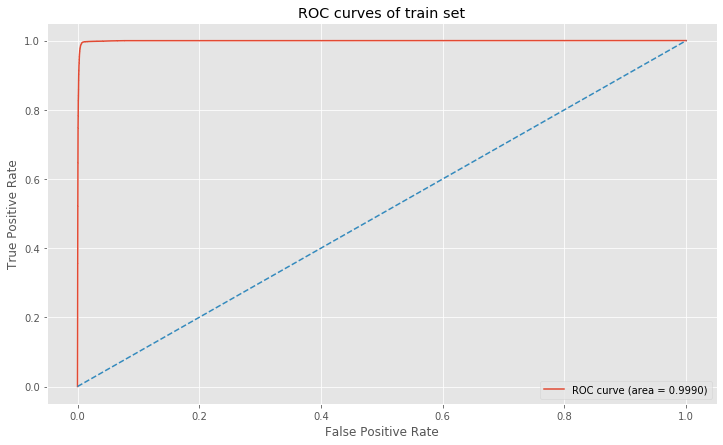

In [67]:
modelReport(smote_weka_trainY.replace({0.0 : 'neg', 1.0 : 'pos'}), weka_train_predict, weka_train_proba, 'train')

In [68]:
weka_test_predict = []
weka_test_proba = []

for inst in weka_test:
    weka_test_predict.append(lmt.classify_instance(inst))
    weka_test_proba.append(lmt.distribution_for_instance(inst))

weka_test_predict = np.array(weka_test_predict).astype('str')
weka_test_predict[weka_test_predict == '0.0'] = 'neg'
weka_test_predict[weka_test_predict == '1.0'] = 'pos'
weka_test_proba = np.array(weka_test_proba)

The confusion for test set is 
[[15102   523]
 [   61   314]]
The classification accuracy is 0.9635


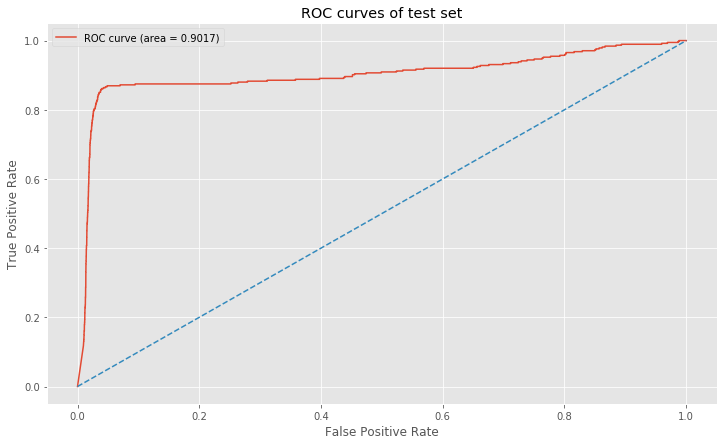

In [69]:
modelReport(test_aps_Y, weka_test_predict, weka_test_proba, 'test')

By comparing the results of LMT model with/without SMOTE, we can see a degradation of ROC and AUC, which implies a overall performance. SInce our dataset is class imblanced, however, this might be a result of missclassification of negative, the majority class. If we observe the confusion matrix, we can see a better precision (267/375 v.s. 314/375) of positive class which is the minority in our dataset. That means SMOTE can really help to imporve the classification of minority class.

In [70]:
jvm.stop()

### 3. ISLR 6.6.3

(a) Steadily increase. Along with the growth of $s$, the values of estimated coefficients will go from 0 to their OLS value. Thus, the traning RSS will steadily decrease.
<br/> (b) Decrease initially, and then eventually start increasing in a U shape. Along with the growth of $s$, the values of estimated coefficients will gradually go non-zero. That means the the numbre of predictors increases and the model becomes more flexible. This may lead to a over-fitting situation.
<br/> (c) Steadily increase. $\beta$s are almost all zero at the beginning. There is almost no variance at the beginning stage. After the model becoming flexible, the variance will goe up.
<br/> (d) Steadily decrease. Bias has a counter-tendency compare with variance as they form a trade-off.
<br/> (e) Remains constant. The irreducible erro is model independent.

### 4. ISLR 6.6.5

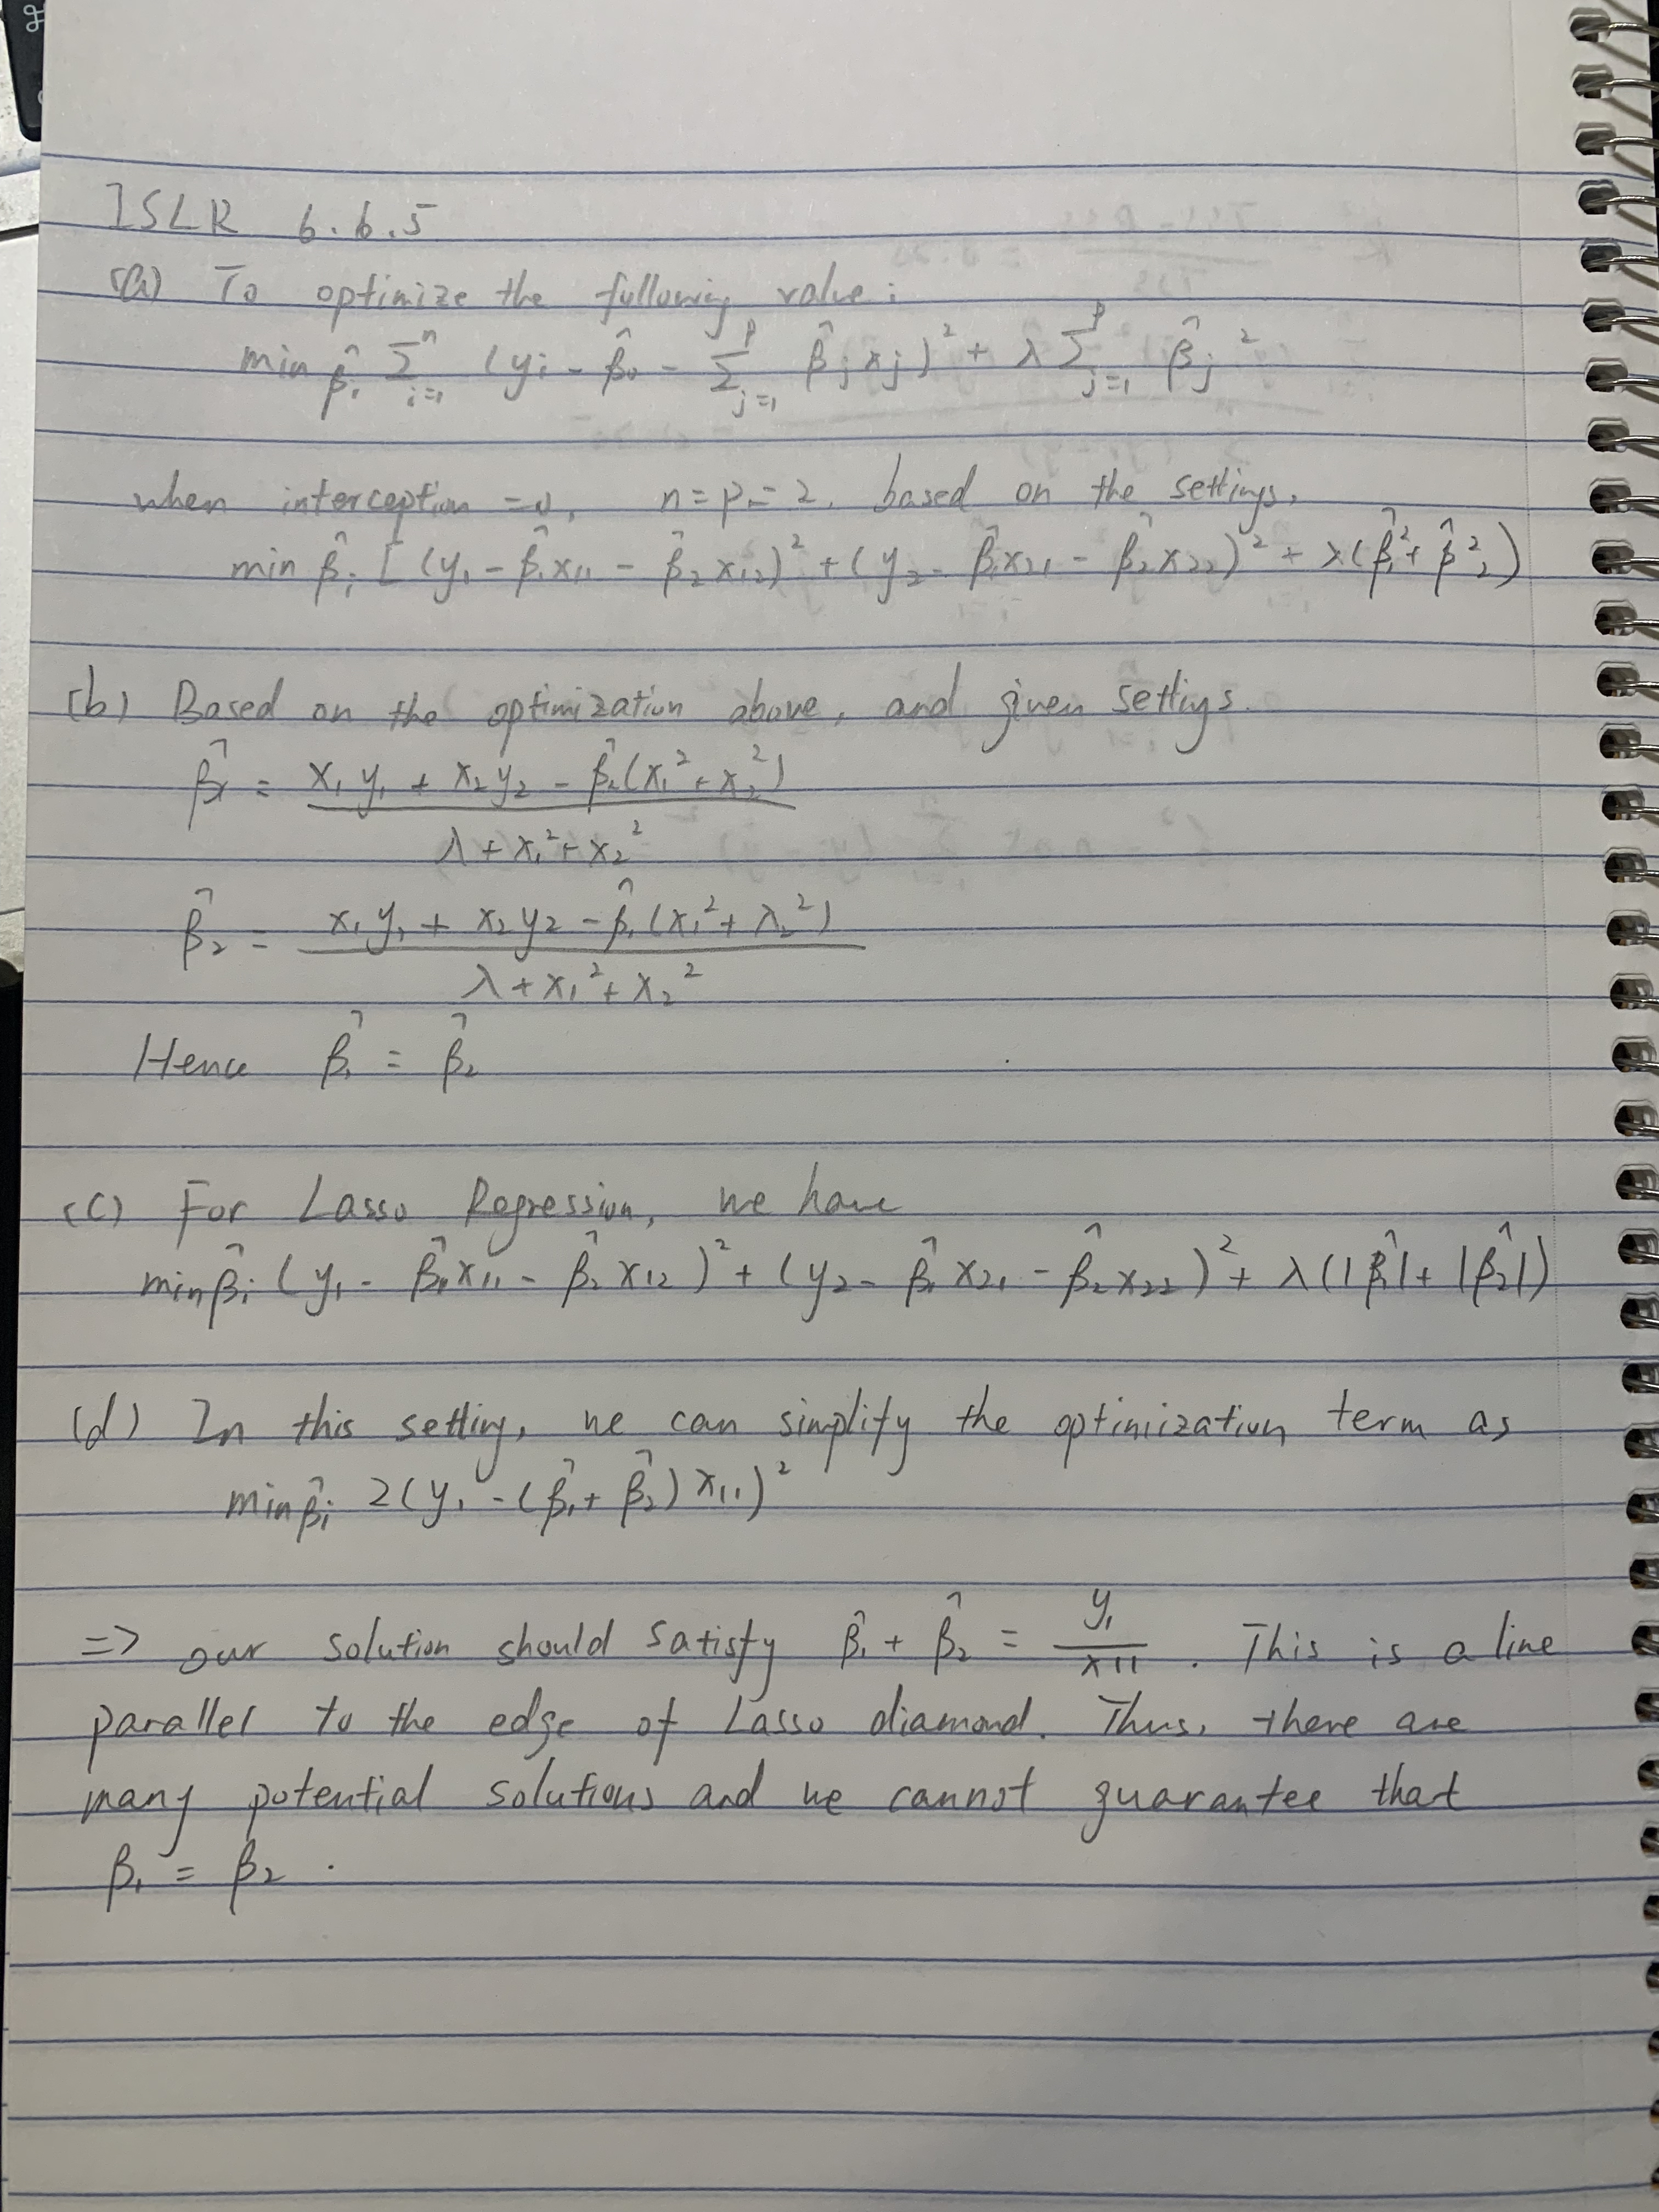

In [66]:
from IPython.display import Image
Image('6.6.5.jpeg')

### 5. ISLR 8.4.5

For the majority polling, red samples has a larger number than grean samples. Thus, the result will be red.
For the average probability method, a mean of 0.45 will lead a prediction of green.

### 6. ISLR 9.7.3

In [67]:
sample_dict = {'X1' : [3, 2, 4, 1, 2, 4, 4], 
           'X2' : [4, 2, 4, 4, 1, 3, 1], 
           'Y' : ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']}
sample_df = pd.DataFrame.from_dict(sample_dict)

In [68]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=10000)
clf.fit(sample_df.iloc[:, :-1], sample_df.iloc[:, -1])

SVC(C=10000, kernel='linear')

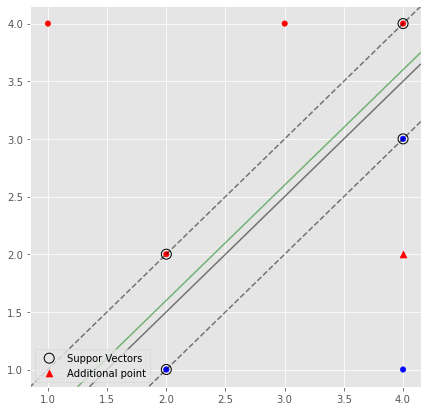

[0.99970703] [[-1.99941406  1.99941406]]


In [69]:
# plot graph
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot of sample points
ax.scatter(sample_df.iloc[:, 0], sample_df.iloc[:, 1], 
           c=sample_df.iloc[:, -1], s=30, 
           cmap=plt.cm.Paired)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

lines1 = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'], label="Decision Boundary")

ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', label="Suppor Vectors")

lines2 = ax.contour(XX, YY, Z - 0.2, colors='g', levels=[0], alpha=0.5,
           linestyles=['-'])

ax.scatter([4.0], [2.0], color='r', marker='^', s=50, label="Additional point")

ax.legend()
plt.show()

print(clf.intercept_, clf.coef_)

(b) The solid black lines is the hyperplane.

(c) We can see, the parameters are approximately:
<br/> β1 = 0, β1 = -2, β2 = 2β0+β1X1+β2X2 > 0 => red, otherwise blue

(d) The dash lines indicates the maximal margin

(e) The circeled ones are support vectors.

(f) The seventh point is far away from the maximal margin hyperplane. If it is on the edge of decision boundary, it will have effects but it does not.

(g) The solid green line.

(h) The new point marked as red triangle. This make the points form an XOR pattern which is not linear-separable.